## About


#### Notes
- using superclean labels
- 99% of images in training set


#### Stats
- Hardware: GTX 2080 Ti


## SETUP

#### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
import time
import shutil
import shapely
from my_scorer import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split(' ')[0])

fastai: 1.0.46
pytorch: 1.0.1.post2
python: 3.6.7


#### Define hyperparameters

In [4]:
version = '20run1'       # this should match the notebook filename

seed = 42
arch = models.resnet50
size = (432, 648)  # (y, x)
bs = 16
num_workers = 8    # set to available cores

In [5]:
# set seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## DATA

#### Download dataset

In [6]:
path = Path.home()/'.fastai/data'

In [7]:
! mkdir -p $path; 
# training set
! cd $path; if [ ! -d Data_Training ]; then wget -nc https://s3.amazonaws.com/herox-alphapilot/Data_Training.zip; unzip -n -q Data_Training.zip; fi
# test set
! cd $path; if [ ! -d Data_LeaderboardTesting ]; then wget -nc https://s3.amazonaws.com/herox-alphapilot/Data_LeaderboardTesting.zip; unzip -n -q Data_LeaderboardTesting.zip; fi
# copy label files from git
! mkdir -p $path/labels
! cp -r labels $path/
# create safe place to store intermediate models
! mkdir -p $path/saved_models

In [8]:
# look at dir
path.ls()

[PosixPath('/root/.fastai/data/Data_Training.zip'),
 PosixPath('/root/.fastai/data/Data_Training'),
 PosixPath('/root/.fastai/data/Data_LeaderboardTesting.zip'),
 PosixPath('/root/.fastai/data/Data_LeaderboardTesting'),
 PosixPath('/root/.fastai/data/bad_community_labels.txt'),
 PosixPath('/root/.fastai/data/bad_official_labels.txt'),
 PosixPath('/root/.fastai/data/training_GT_labels_v2.json'),
 PosixPath('/root/.fastai/data/training_community_labels.json'),
 PosixPath('/root/.fastai/data/saved_models'),
 PosixPath('/root/.fastai/data/training_combined_labels.json'),
 PosixPath('/root/.fastai/data/results_v18run1_stage11_valid.json'),
 PosixPath('/root/.fastai/data/labels_v18run1_stage11_valid.json'),
 PosixPath('/root/.fastai/data/results_v18run1_stage12_valid.json'),
 PosixPath('/root/.fastai/data/labels_v18run1_stage12_valid.json'),
 PosixPath('/root/.fastai/data/results_v18run1_stage13_valid.json'),
 PosixPath('/root/.fastai/data/labels_v18run1_stage13_valid.json'),
 PosixPath('/ro

In [9]:
# look at images dir
orig_img_path = path/'Data_Training'
orig_img_path.ls()[:5]

[PosixPath('/root/.fastai/data/Data_Training/IMG_0005.JPG'),
 PosixPath('/root/.fastai/data/Data_Training/IMG_0006.JPG'),
 PosixPath('/root/.fastai/data/Data_Training/IMG_0007.JPG'),
 PosixPath('/root/.fastai/data/Data_Training/IMG_0012.JPG'),
 PosixPath('/root/.fastai/data/Data_Training/IMG_0013.JPG')]

In [10]:
# look at saved models dir
save_path = path/'saved_models'
save_path.ls()[:5]

[PosixPath('/root/.fastai/data/saved_models/v19run3-stage-1-1.pth'),
 PosixPath('/root/.fastai/data/saved_models/v19run3-stage-1-2.pth'),
 PosixPath('/root/.fastai/data/saved_models/v20run1-stage-2-1.pth')]

In [11]:
# look at labels dir
labels_dir = path/'labels'
labels_dir.ls()[:5]

[PosixPath('/root/.fastai/data/labels/training_community_labels.json'),
 PosixPath('/root/.fastai/data/labels/README.md'),
 PosixPath('/root/.fastai/data/labels/fixed_9299.json'),
 PosixPath('/root/.fastai/data/labels/training_GT_labels_v2.json'),
 PosixPath('/root/.fastai/data/labels/poor_community_labels.txt')]

#### Define helper functions for labels

In [12]:
# load bad labels from file
# format is text file with comments
def load_bad_labels(fname):
    with open(fname, 'r') as f:
        bad_labels = f.readlines()

    bad_labels = set([item.strip('\n') for item in bad_labels if item.startswith('IMG')])
    return bad_labels

#### Drop bad community labels
Start from community labels that have been touched up by hand.  Images where all four corners of the gate are not visible should be dropped.  Also dropping 6 images with no gate as the model currently doesn't have class detection.  Also dropping one image with junk artifacts.  Most images have already been removed from the base file.

In [13]:
# load full community label set
df = pd.read_json(labels_dir/'training_superclean_labels.json')
n_labels_before = len(df.keys())
# load bad labels
bad_labels = load_bad_labels(labels_dir/'bad_community_labels.txt')

In [14]:
# drop bad labels from dataframe
n_dropped = 0
for fname in bad_labels:
    try:
        df = df.drop(fname, 1)
        n_dropped += 1
    except:
        pass
n_labels_after = len(df.keys())

In [15]:
# show results
print('before: ', n_labels_before)
print('dropped:', n_dropped)
print('after:  ', n_labels_after)

before:  9253
dropped: 1
after:   9252


In [16]:
# create ground truth label file based on this set to use during mAP scoring
label_path = labels_dir/'training_combined_labels.json'
df_gt = pd.DataFrame()
for key in df.keys():
    df_gt[key] = [df[key]]
write_json(df_gt, label_path)

In [17]:
# create new image dir only of images with good labels
img_path = path/'good_images'

# remove existing good image dir
if os.path.isdir(img_path):
    shutil.rmtree(img_path)
# copy files
os.mkdir(img_path)
for fname in df.keys():
    shutil.copyfile(orig_img_path/fname, img_path/fname)

#### Do sanity checks

In [18]:
df.head()

IMG_0005.JPG  \
0  [432, 253, 698, 264, 696, 525, 428, 528]   

                               IMG_0006.JPG  \
0  [307, 210, 609, 238, 610, 527, 305, 533]   

                              IMG_0012.JPG  \
0  [352, 63, 794, 110, 799, 538, 350, 548]   

                                 IMG_0013.JPG  \
0  [570, 142, 1019, 140, 1038, 595, 566, 597]   

                               IMG_0015.JPG  \
0  [504, 191, 903, 173, 913, 588, 494, 587]   

                               IMG_0016.JPG  \
0  [410, 256, 750, 245, 753, 594, 403, 594]   

                               IMG_0022.JPG  \
0  [402, 326, 644, 330, 646, 571, 397, 575]   

                               IMG_0024.JPG  \
0  [385, 254, 720, 255, 722, 592, 378, 592]   

                               IMG_0028.JPG  \
0  [417, 152, 860, 150, 871, 594, 411, 600]   

                               IMG_0029.JPG  ...  \
0  [442, 160, 878, 158, 891, 594, 436, 598]  ...   

                               IMG_9988.JPG  \
0  [588, 404, 700, 404, 702, 518, 588, 519]   

                               IMG_9989.JPG  \
0  [559, 404, 669, 402, 673, 513, 562, 519]   

                               IMG_9990.JPG  \
0  [870, 399, 988, 395, 991, 509, 872, 514]   

                               IMG_9992.JPG  \
0  [571, 312, 768, 315, 769, 512, 570, 514]   

                               IMG_9993.JPG  \
0  [631, 306, 832, 311, 832, 511, 630, 511]   

                               IMG_9994.JPG  \
0  [663, 302, 872, 300, 870, 513, 665, 515]   

                               IMG_9995.JPG  \
0  [687, 295, 898, 295, 899, 506, 689, 506]   

                                        IMG_9997.JPG  \
0  [701.0, 282.0, 921.1239669421, 279.4349442379,...   

                               IMG_9998.JPG  \
0  [634, 283, 859, 286, 861, 509, 637, 512]   

                               IMG_9999.JPG  
0  [567, 280, 796, 285, 796, 514, 570, 514]  

[1 rows x 9252 columns]

In [19]:
# number of images and labels
print('images: ', len([fname for fname in os.listdir(img_path) if fname.endswith('JPG')]))
print('labels: ', len(df.keys()))

images:  9252
labels:  9252


## MODEL

#### Define helper functions to load data

In [20]:
# coordinates need to be tranformed from (x,y) to (y,x) before feeding to model
def flip_xy(coords):
    result = []
    for i in range(0, len(coords), 2):
        result.append(coords[i+1])
        result.append(coords[i])
    return result

In [21]:
# each image label is a 2d tensor of 4 (y,x) points
def gen_label(path):
    coords = flip_xy(df[path.name][0])
    return tensor(coords).reshape(4,2).float()

#### Create datablock

In [22]:
# specify data augmentation: zoom, flip, rotate, lighting, warp
tfms = get_transforms(max_rotate=3.)  

In [23]:
# split data into train, valid and test sets
# need a fake label to satisfy the API, not used in any meaningful way
fake_label = tensor([0.] * 8).reshape(4,2)
src = (PointsItemList.from_folder(img_path)
        .random_split_by_pct(valid_pct=0.01)
        .label_from_func(gen_label)
        .add_test_folder('../Data_LeaderboardTesting', label=fake_label))

In [24]:
# create databunch
# apply transforms to y as well
# setting remove_out=False means that points that fall outside the bounds of the image are NOT removed
# more details here: https://forums.fast.ai/t/failing-with-face-landmarks-data-preparation/34317/4
data = (src.transform(tfms, tfm_y=True, resize_method=ResizeMethod.SQUISH, size=size, remove_out=False)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

#### Do sanity checks

In [25]:
# verify datasets loaded properly
n_train_items = len(data.train_ds)
n_valid_items = len(data.valid_ds)
n_test_items = len(data.test_ds)

print('train: ', n_train_items)
print('valid: ', n_valid_items)
print('test:  ', n_test_items)
print('')
print('TOTAL: ', n_train_items + n_valid_items + n_test_items)

train:  9160
valid:  92
test:   1161

TOTAL:  10413


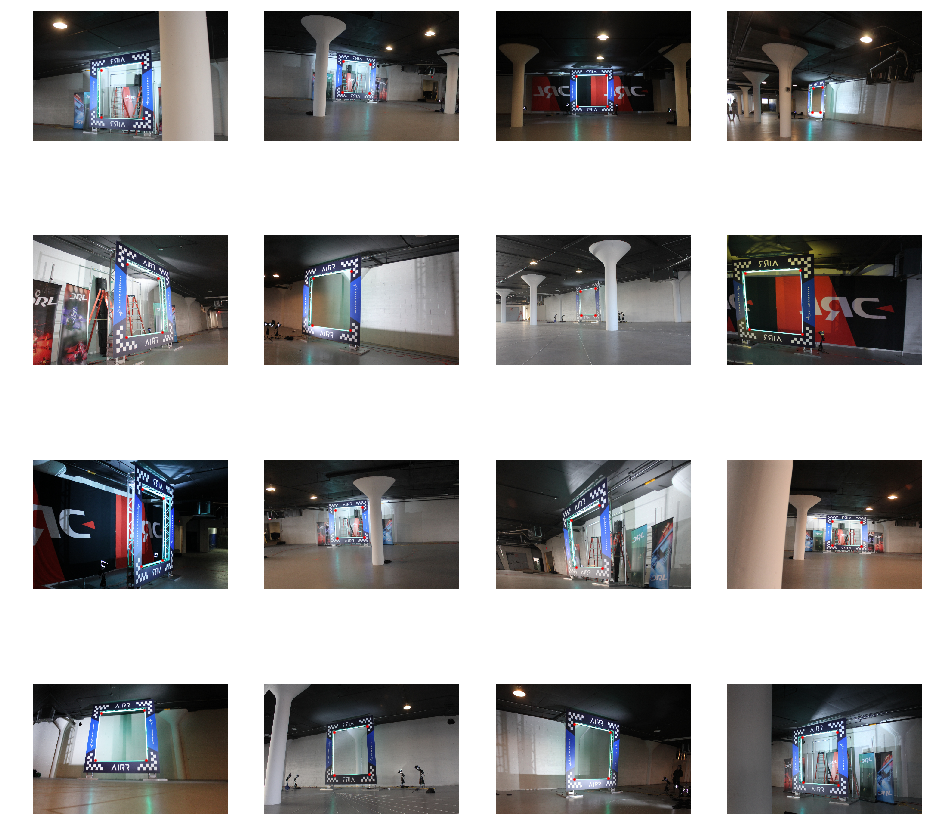

In [26]:
# verify labels are going through same transformations as images
data.show_batch(4, figsize=(13, 13))

#### Define metrics

In [27]:
# mean pixel offset (using pythorgean theorem)
# will look worse as image size increases
def pxls(preds, targs):
    preds = preds.reshape(-1,4,2)  # reshape to match targs
    # scale preds
    preds[:,:,0] = (preds[:,:,0] + 1) * (size[1] / 2)  # x
    preds[:,:,1] = (preds[:,:,1] + 1) * (size[0] / 2)  # y
    # scale targs
    targs[:,:,0] = (targs[:,:,0] + 1) * (size[1] / 2)  # x
    targs[:,:,1] = (targs[:,:,1] + 1) * (size[0] / 2)  # y
    # calculate the square of the differences between target and preds
    sqr_diff = (targs - preds) ** 2
    # sum the x and y offsets of each coordinate and take the square root
    # return the mean of all four coordinates
    return torch.mean(torch.sqrt(sqr_diff.sum(dim=2)))

# just rename
def mse(preds, targs):
    return mean_squared_error(preds, targs)

# just rename
def mae(preds, targs):
    return mean_absolute_error(preds, targs)

#### Define loss functions

In [28]:
# L1 loss is sum of the all the absolute differences
# more robust to outliers
l1loss = nn.L1Loss()
def l1_loss(preds, targs):
    preds = preds.reshape(-1,4,2)  # reshape to match targs
    return l1loss(preds, targs)

# L2 loss is sum of the all the squared differences
# less robust to outliers
l2loss = nn.MSELoss()
def l2_loss(preds, targs):
    preds = preds.reshape(-1,4,2)  # reshape to match targs
    return l2loss(preds, targs)

#### Define custom head

In [29]:
# return correct size of fully connected layer based on pre-trained model
def final_conv_layer_size(arch):
    if arch == models.resnet18 and size == (432, 648): return 512*14*21
    elif arch == models.resnet34 and size == (512, 512): return 512*7*7  
    elif arch == models.resnet50 and size == (512, 512): return 2048*16*16
    elif arch == models.resnet50 and size == (432, 648): return 2048*14*21

In [30]:
# define linear layer that maps final conv layer to output
head_reg8 = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 8))

#### Create learner

In [31]:
# create learner with custom head
# choose desired loss and metrics
learn = create_cnn(data, arch, custom_head=head_reg8, loss_func=l2_loss, metrics=[mae, pxls])

In [32]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 216, 324]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 216, 324]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 216, 324]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 108, 162]    0          False     
______________________________________________________________________
Conv2d               [1, 64, 108, 162]    4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 108, 162]    128        True      
______________________________________________________________________
Conv2d               [1, 64, 108, 162]    36,864     False     
______________________________________________________________

## TRAIN

- Stage 1: frozen model (only head trains)
- Stage 2: unfrozen model (all layers train)

#### Stage 1.1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


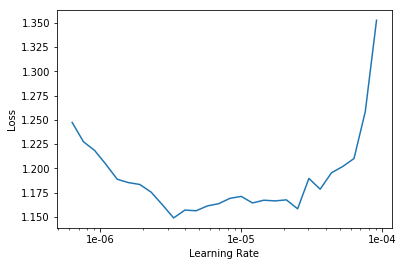

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(10, max_lr=slice(4e-6))  # default 10

In [38]:
learn.save(save_path/f'v{version}-stage-1-1')

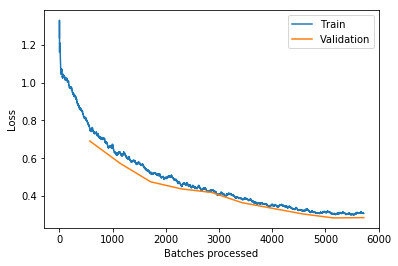

In [39]:
learn.recorder.plot_losses()

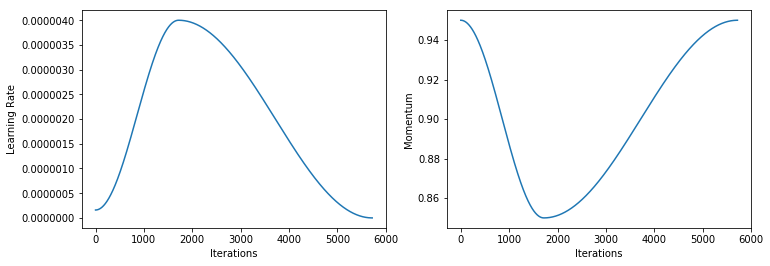

In [40]:
learn.recorder.plot_lr(show_moms=True)

##### Results

In [41]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage11_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

total inference time: 2.37 seconds
average inference time: 0.03 seconds


In [42]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage11_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

IOU: 0.05   Precision: 0.403
IOU: 0.15   Precision: 0.148
IOU: 0.25   Precision: 0.037
IOU: 0.35   Precision: 0.005
IOU: 0.45   Precision: 0.001
IOU: 0.55   Precision: 0.001
IOU: 0.65   Precision: 0.000
IOU: 0.75   Precision: 0.000
IOU: 0.85   Precision: 0.000
IOU: 0.95   Precision: 0.000
COCO mAP for detector is 0.05956695321806883


#### Stage 1.2

In [43]:
#learn.load(save_path/f'v{version}-stage-1-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


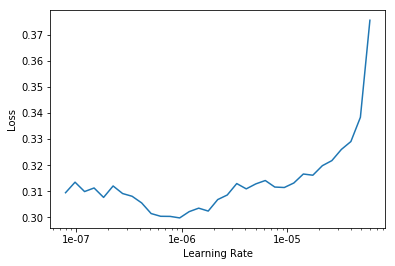

In [44]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(20, max_lr=slice(1.5e-6))  # default 20

In [46]:
learn.save(save_path/f'v{version}-stage-1-2')

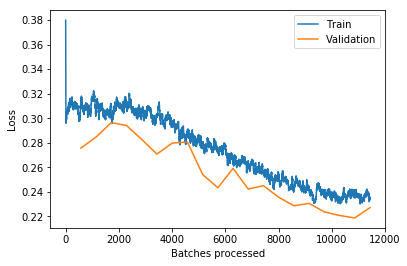

In [47]:
learn.recorder.plot_losses()

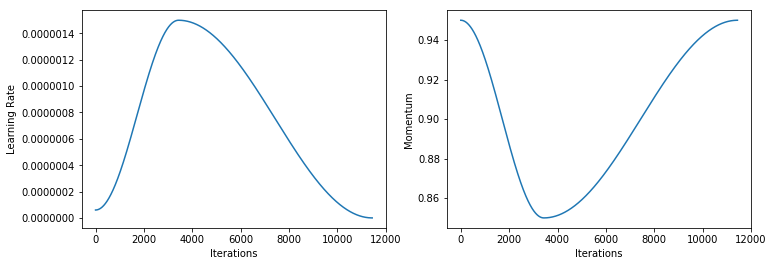

In [48]:
learn.recorder.plot_lr(show_moms=True)

##### Results

In [49]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage12_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

total inference time: 2.33 seconds
average inference time: 0.03 seconds


In [50]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage12_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

IOU: 0.05   Precision: 0.499
IOU: 0.15   Precision: 0.255
IOU: 0.25   Precision: 0.072
IOU: 0.35   Precision: 0.015
IOU: 0.45   Precision: 0.001
IOU: 0.55   Precision: 0.001
IOU: 0.65   Precision: 0.000
IOU: 0.75   Precision: 0.000
IOU: 0.85   Precision: 0.000
IOU: 0.95   Precision: 0.000
COCO mAP for detector is 0.0843761853726875


#### Stage 1.3

In [51]:
#learn.load(save_path/f'v{version}-stage-1-3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


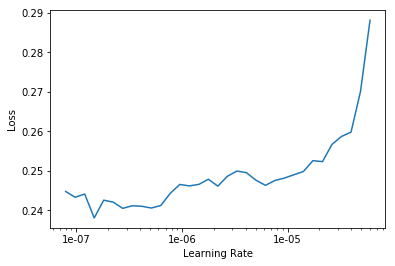

In [52]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(40, max_lr=slice(1e-6))  # default 40

In [54]:
learn.save(save_path/f'v{version}-stage-1-3')

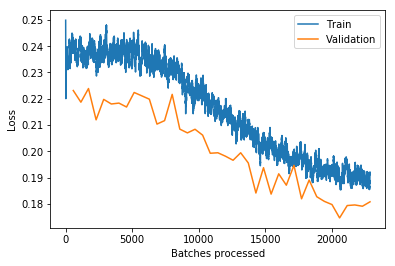

In [55]:
learn.recorder.plot_losses()

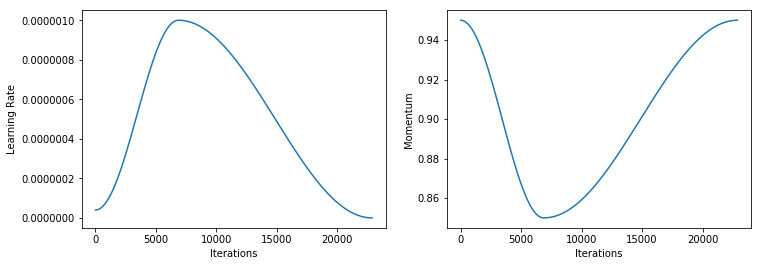

In [56]:
learn.recorder.plot_lr(show_moms=True)

##### Results

In [57]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage13_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

total inference time: 2.36 seconds
average inference time: 0.03 seconds


In [58]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage13_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

IOU: 0.05   Precision: 0.483
IOU: 0.15   Precision: 0.176
IOU: 0.25   Precision: 0.078
IOU: 0.35   Precision: 0.011
IOU: 0.45   Precision: 0.011
IOU: 0.55   Precision: 0.000
IOU: 0.65   Precision: 0.000
IOU: 0.75   Precision: 0.000
IOU: 0.85   Precision: 0.000
IOU: 0.95   Precision: 0.000
COCO mAP for detector is 0.07594265183338719


#### Stage 2.1 

In [59]:
#learn.load(save_path/f'v{version}-stage-1-3');

In [60]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


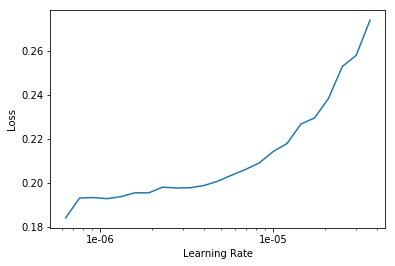

In [61]:
learn.lr_find()
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(300, max_lr=slice(5e-7, 5e-6))  # default 300

In [63]:
learn.save(save_path/f'v{version}-stage-2-1')

In [64]:
torch.save(learn.model, save_path/f'v{version}-stage-2-1-torch.pth')

In [65]:
learn.export(save_path/f'v{version}-stage-2-1-export.pkl')

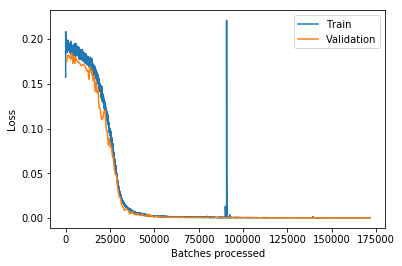

In [66]:
learn.recorder.plot_losses()

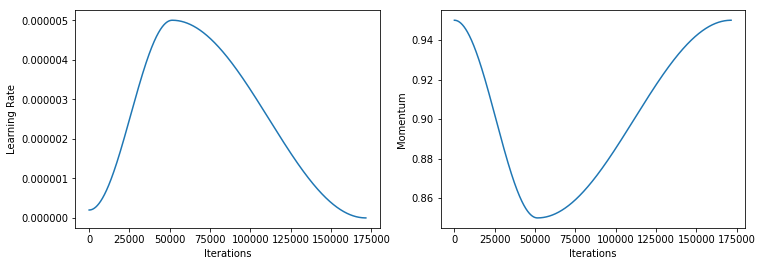

In [67]:
learn.recorder.plot_lr(show_moms=True)

##### Results

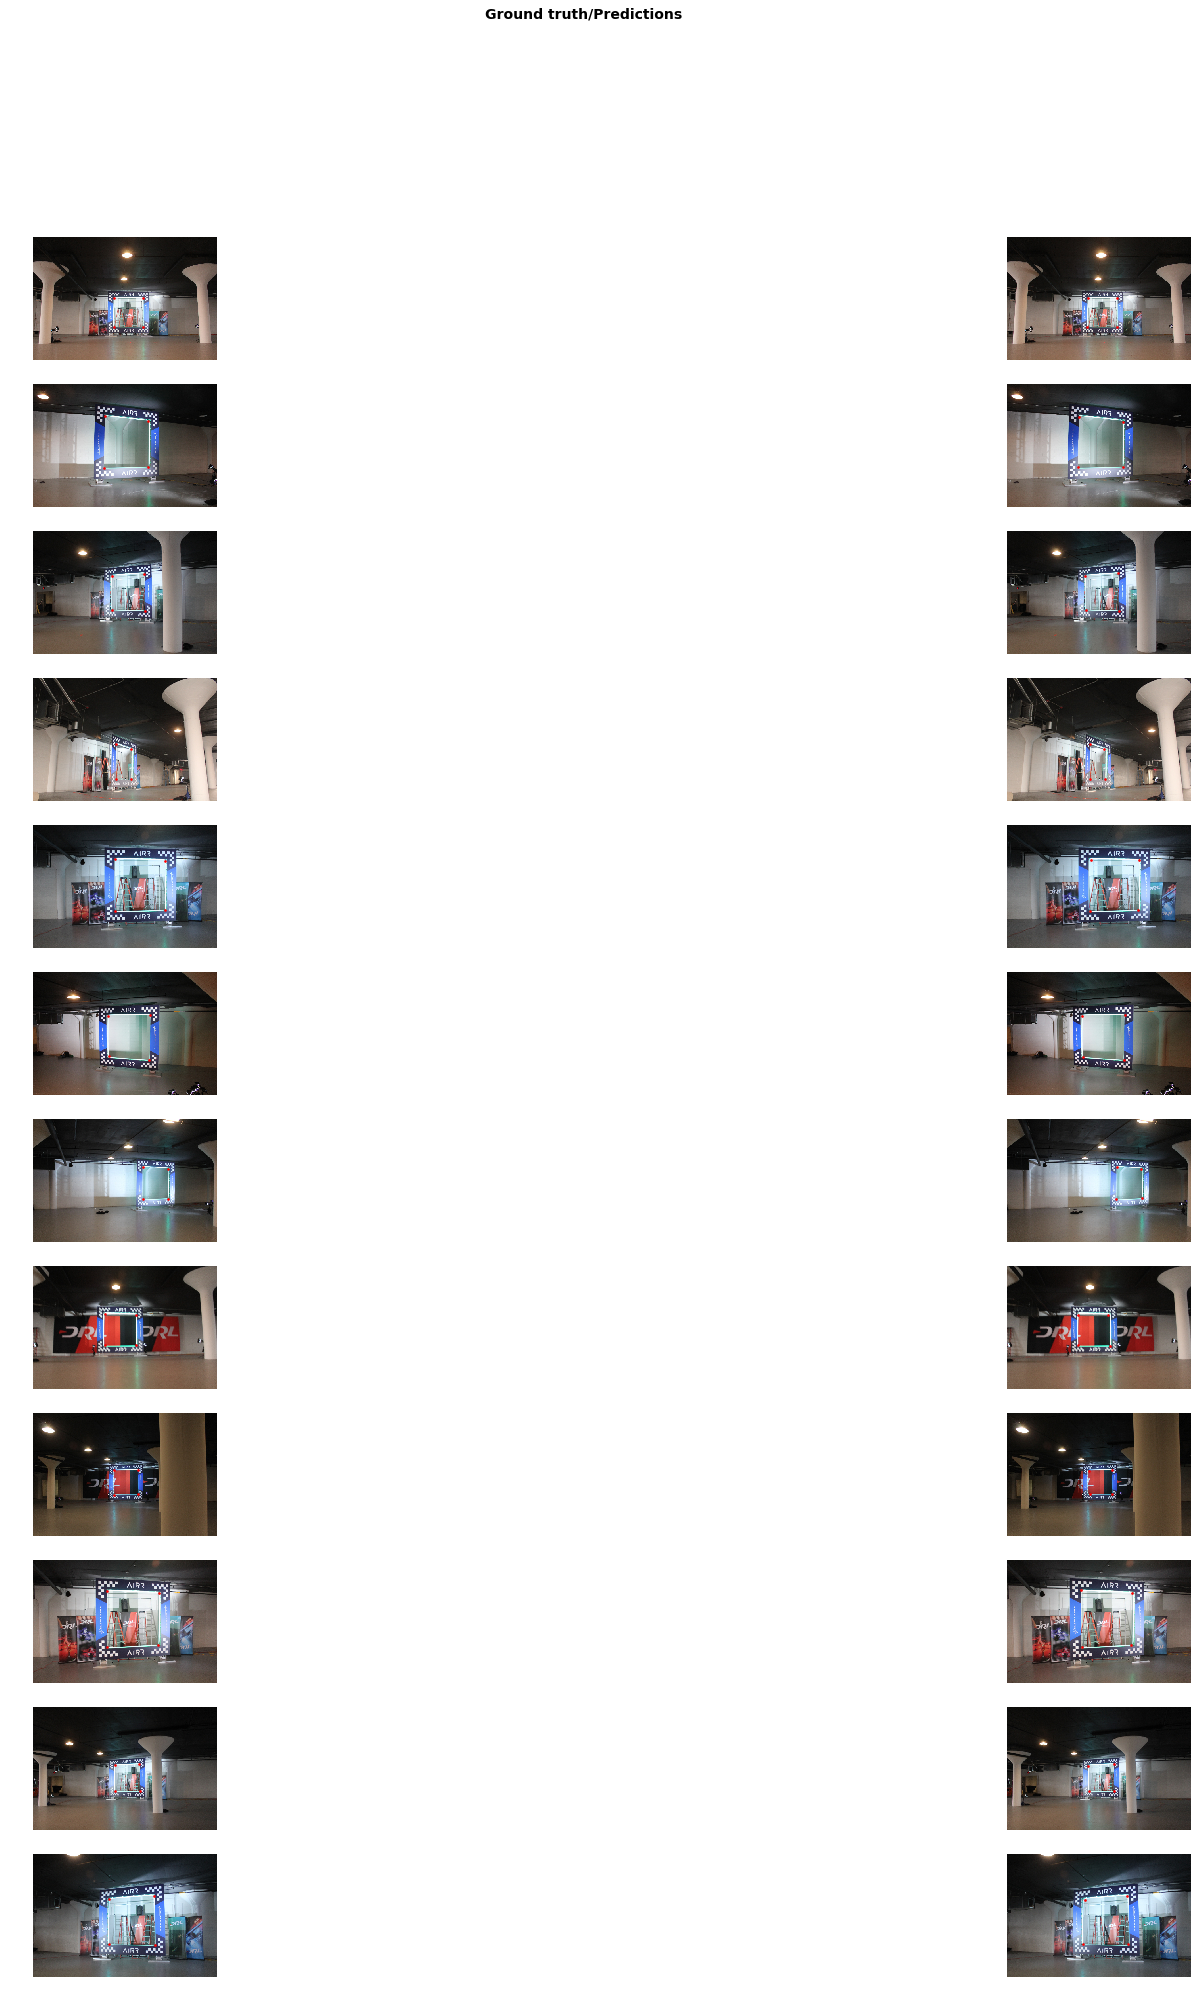

In [68]:
learn.show_results(rows=12, figsize=(32,32))

In [69]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage21_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

total inference time: 2.40 seconds
average inference time: 0.03 seconds


In [70]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage21_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 1.000
IOU: 0.25   Precision: 1.000
IOU: 0.35   Precision: 1.000
IOU: 0.45   Precision: 1.000
IOU: 0.55   Precision: 1.000
IOU: 0.65   Precision: 0.909
IOU: 0.75   Precision: 0.909
IOU: 0.85   Precision: 0.889
IOU: 0.95   Precision: 0.299
COCO mAP for detector is 0.9006360422585198


In [71]:
# generate predictions on test set
tic = time.monotonic()
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)
toc = time.monotonic()

test_preds_fname = path/f'results_v{version}_stage21_test.json'
write_preds_json(data.test_ds, test_preds, size, test_preds_fname)

inference_time(test_preds, tic, toc)

total inference time: 16.72 seconds
average inference time: 0.01 seconds


In [72]:
# score test set
print('To score the test set submit this JSON file to the leaderboard:')
print(test_preds_fname)

To score the test set submit this JSON file to the leaderboard:
/root/.fastai/data/results_v20run1_stage21_test.json


In [73]:
# generate predictions on training set
tic = time.monotonic()
train_preds, _ = learn.get_preds(ds_type=DatasetType.Fix)
toc = time.monotonic()

train_preds_fname = path/f'results_v{version}_stage21_train.json'
write_preds_json(data.train_ds, train_preds, size, train_preds_fname)

inference_time(train_preds, tic, toc)

total inference time: 91.17 seconds
average inference time: 0.01 seconds


In [74]:
# score training set
train_labels_fname = path/f'labels_v{version}_stage21_train.json'
write_labels_json(train_preds_fname, label_path, train_labels_fname)
score(train_labels_fname, train_preds_fname)

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 0.909
IOU: 0.25   Precision: 0.909
IOU: 0.35   Precision: 0.909
IOU: 0.45   Precision: 0.909
IOU: 0.55   Precision: 0.908
IOU: 0.65   Precision: 0.906
IOU: 0.75   Precision: 0.898
IOU: 0.85   Precision: 0.857
IOU: 0.95   Precision: 0.253
COCO mAP for detector is 0.8458163394145692


In [75]:
# download data back to local
print('Run these commands locally to sync the important stuff!')
print('')
# notebook
print(f'scp -P $VAST_PORT $VAST_HOST:test2/train_v{version}.ipynb $GITREPO')

# results
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v{version}*.json $GITREPO/results')

# models
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v{version}-stage-2-1* $MODELDIR')

Run these commands locally to sync the important stuff!

scp -P $VAST_PORT $VAST_HOST:test2/train_v20run1.ipynb $GITREPO
scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v20run1*.json $GITREPO/results
scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v20run1-stage-2-1* $MODELDIR


#### Stage 2.2

In [33]:
learn.load(save_path/f'v{version}-stage-2-1');

In [34]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


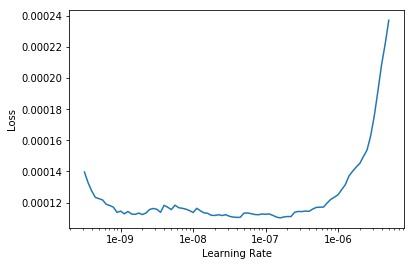

In [35]:
learn.lr_find(start_lr=1e-10, end_lr=1e-5, stop_div=False)
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(120, max_lr=slice(2e-8, 2e-7))  # default 200

In [37]:
learn.save(save_path/f'v{version}-stage-2-2')

In [38]:
torch.save(learn.model, save_path/f'v{version}-stage-2-2-torch.pth')

In [39]:
learn.export(save_path/f'v{version}-stage-2-2-export.pkl')

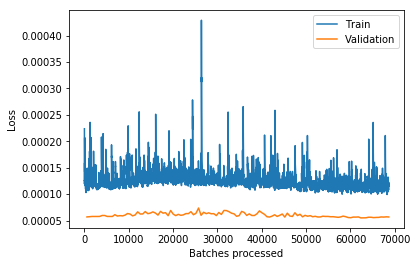

In [40]:
learn.recorder.plot_losses()

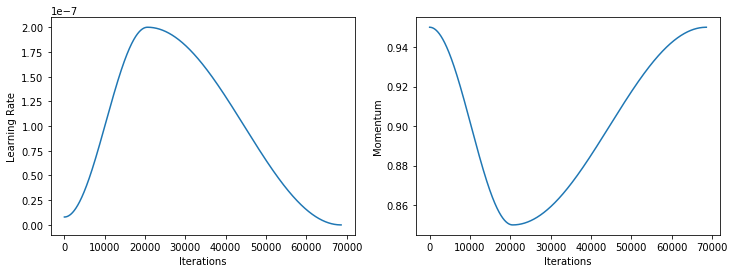

In [41]:
learn.recorder.plot_lr(show_moms=True)

##### Results

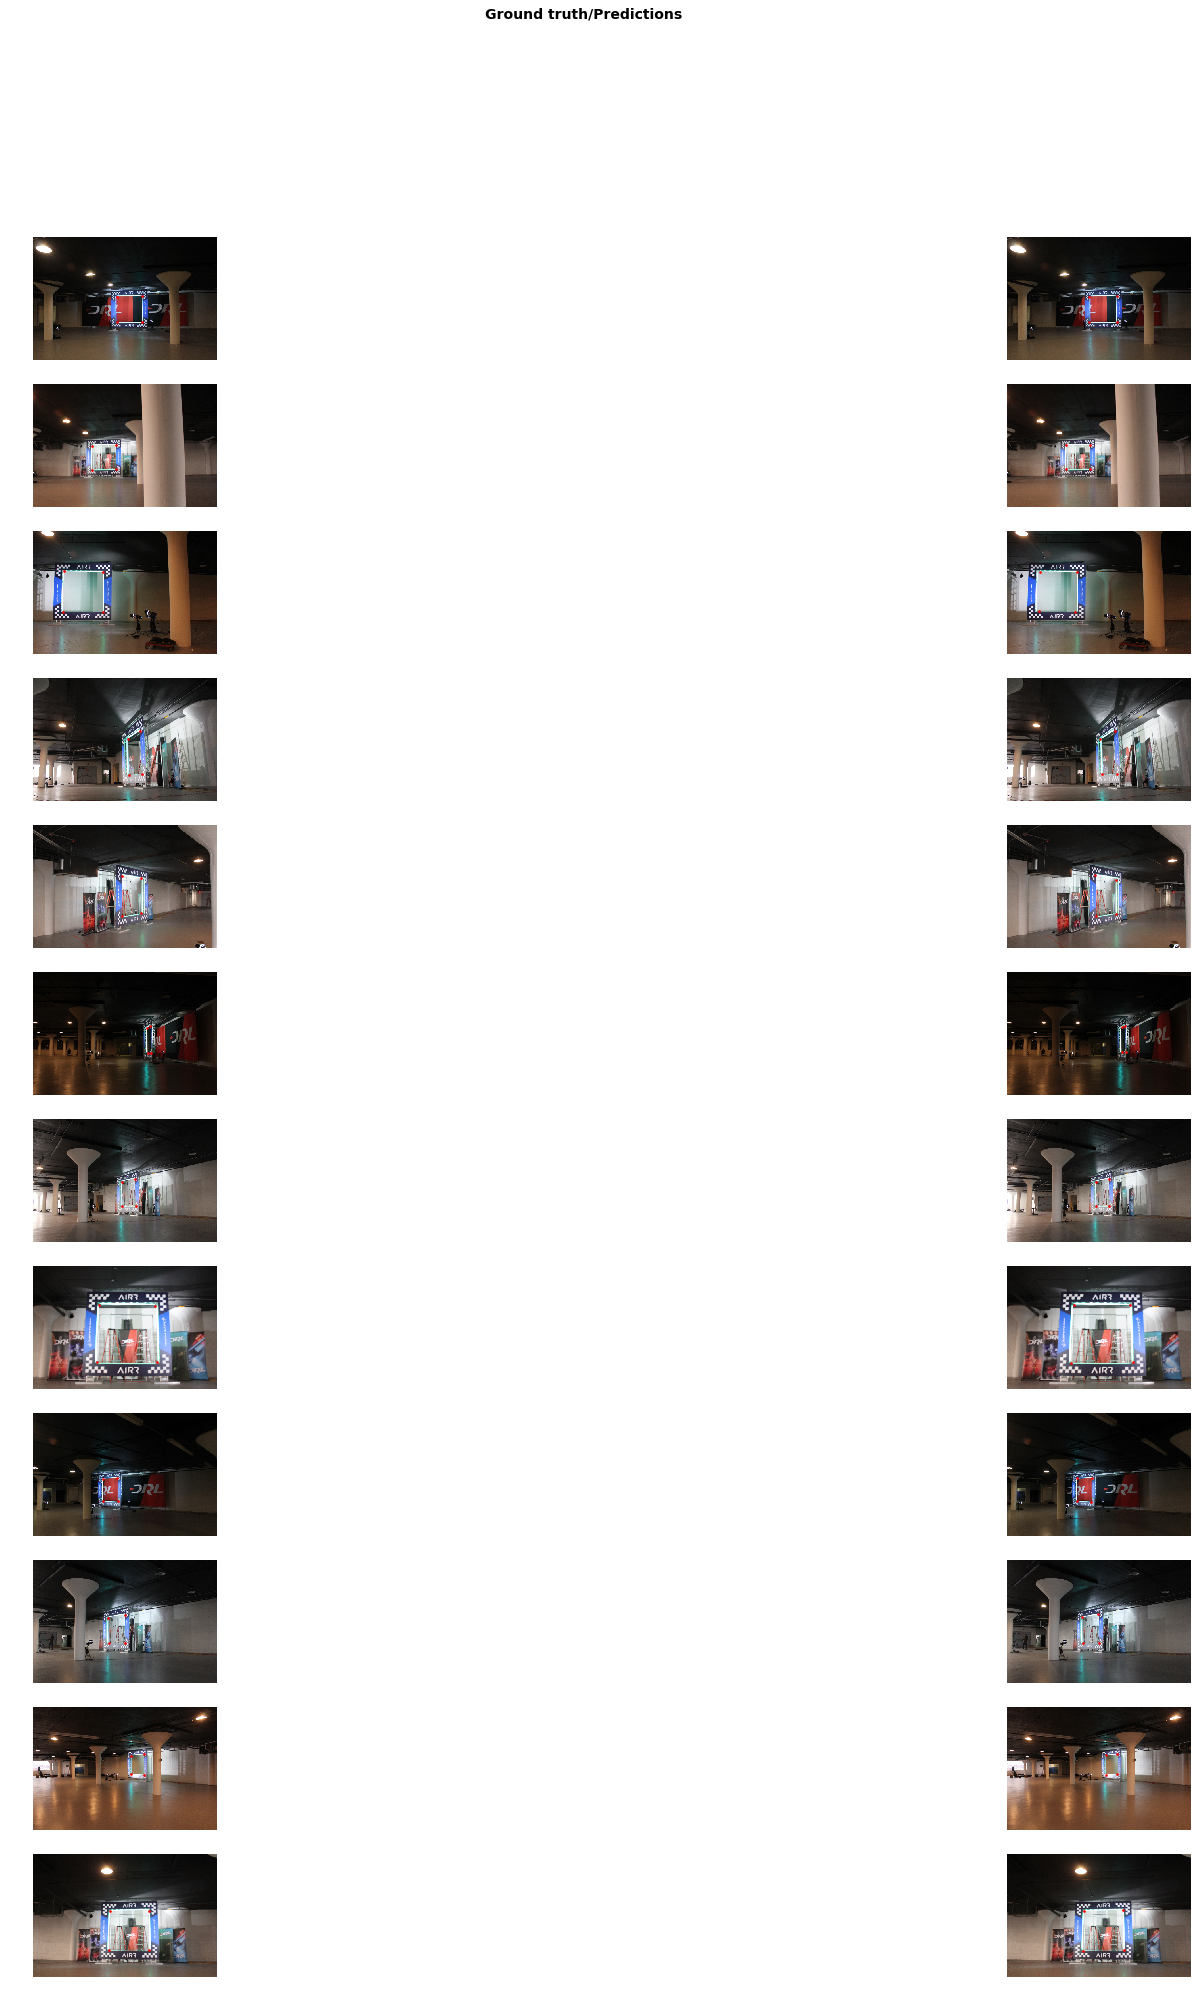

In [42]:
learn.show_results(rows=12, figsize=(32,32))

In [43]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage22_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

total inference time: 2.81 seconds
average inference time: 0.03 seconds


In [44]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage22_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 1.000
IOU: 0.25   Precision: 1.000
IOU: 0.35   Precision: 1.000
IOU: 0.45   Precision: 1.000
IOU: 0.55   Precision: 1.000
IOU: 0.65   Precision: 0.902
IOU: 0.75   Precision: 0.877
IOU: 0.85   Precision: 0.738
IOU: 0.95   Precision: 0.207
COCO mAP for detector is 0.8724473941451871


In [45]:
# generate predictions on test set
tic = time.monotonic()
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)
toc = time.monotonic()

test_preds_fname = path/f'results_v{version}_stage22_test.json'
write_preds_json(data.test_ds, test_preds, size, test_preds_fname)

inference_time(test_preds, tic, toc)

total inference time: 19.07 seconds
average inference time: 0.02 seconds


In [46]:
# score test set
print('To score the test set submit this JSON file to the leaderboard:')
print(test_preds_fname)

To score the test set submit this JSON file to the leaderboard:
/root/.fastai/data/results_v20run1_stage22_test.json


In [47]:
# generate predictions on training set
tic = time.monotonic()
train_preds, _ = learn.get_preds(ds_type=DatasetType.Fix)
toc = time.monotonic()

train_preds_fname = path/f'results_v{version}_stage22_train.json'
write_preds_json(data.train_ds, train_preds, size, train_preds_fname)

inference_time(train_preds, tic, toc)

total inference time: 105.74 seconds
average inference time: 0.01 seconds


In [48]:
# score training set
train_labels_fname = path/f'labels_v{version}_stage22_train.json'
write_labels_json(train_preds_fname, label_path, train_labels_fname)
score(train_labels_fname, train_preds_fname)

IOU: 0.05   Precision: 0.909
IOU: 0.15   Precision: 0.909
IOU: 0.25   Precision: 0.909
IOU: 0.35   Precision: 0.909
IOU: 0.45   Precision: 0.909
IOU: 0.55   Precision: 0.908
IOU: 0.65   Precision: 0.907
IOU: 0.75   Precision: 0.899
IOU: 0.85   Precision: 0.861
IOU: 0.95   Precision: 0.259
COCO mAP for detector is 0.8378678995752983


In [49]:
# download data back to local
print('Run these commands locally to sync the important stuff!')
print('')
# notebook
print(f'scp -P $VAST_PORT $VAST_HOST:test2/train_v{version}.ipynb $GITREPO')

# results
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v{version}*.json $GITREPO/results')

# models
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v{version}-stage-2-2* $MODELDIR')

Run these commands locally to sync the important stuff!

scp -P $VAST_PORT $VAST_HOST:test2/train_v20run1.ipynb $GITREPO
scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v20run1*.json $GITREPO/results
scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v20run1-stage-2-2* $MODELDIR


#### Stage 2.3

In [50]:
#learn.load(save_path/f'v{version}-stage-2-2');

In [51]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


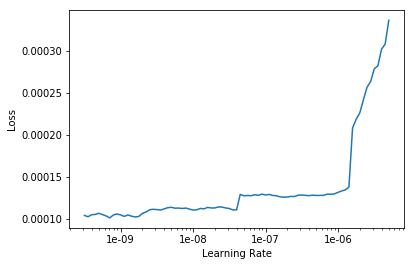

In [52]:
learn.lr_find(start_lr=1e-10, end_lr=1e-5, stop_div=False)
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(120, max_lr=slice(2e-8, 2e-7))  # default 200

In [54]:
learn.save(save_path/f'v{version}-stage-2-3')

In [55]:
torch.save(learn.model, save_path/f'v{version}-stage-2-3-torch.pth')

In [56]:
learn.export(save_path/f'v{version}-stage-2-3-export.pkl')

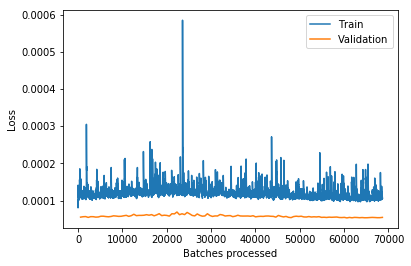

In [57]:
learn.recorder.plot_losses()

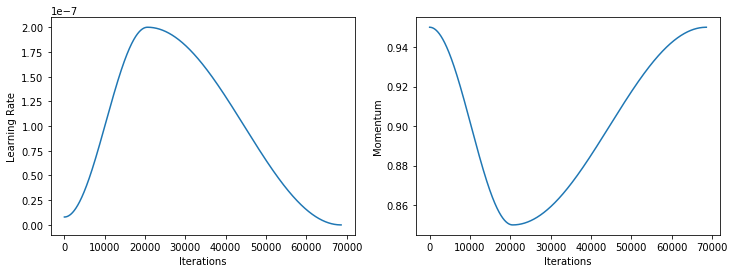

In [58]:
learn.recorder.plot_lr(show_moms=True)

##### Results

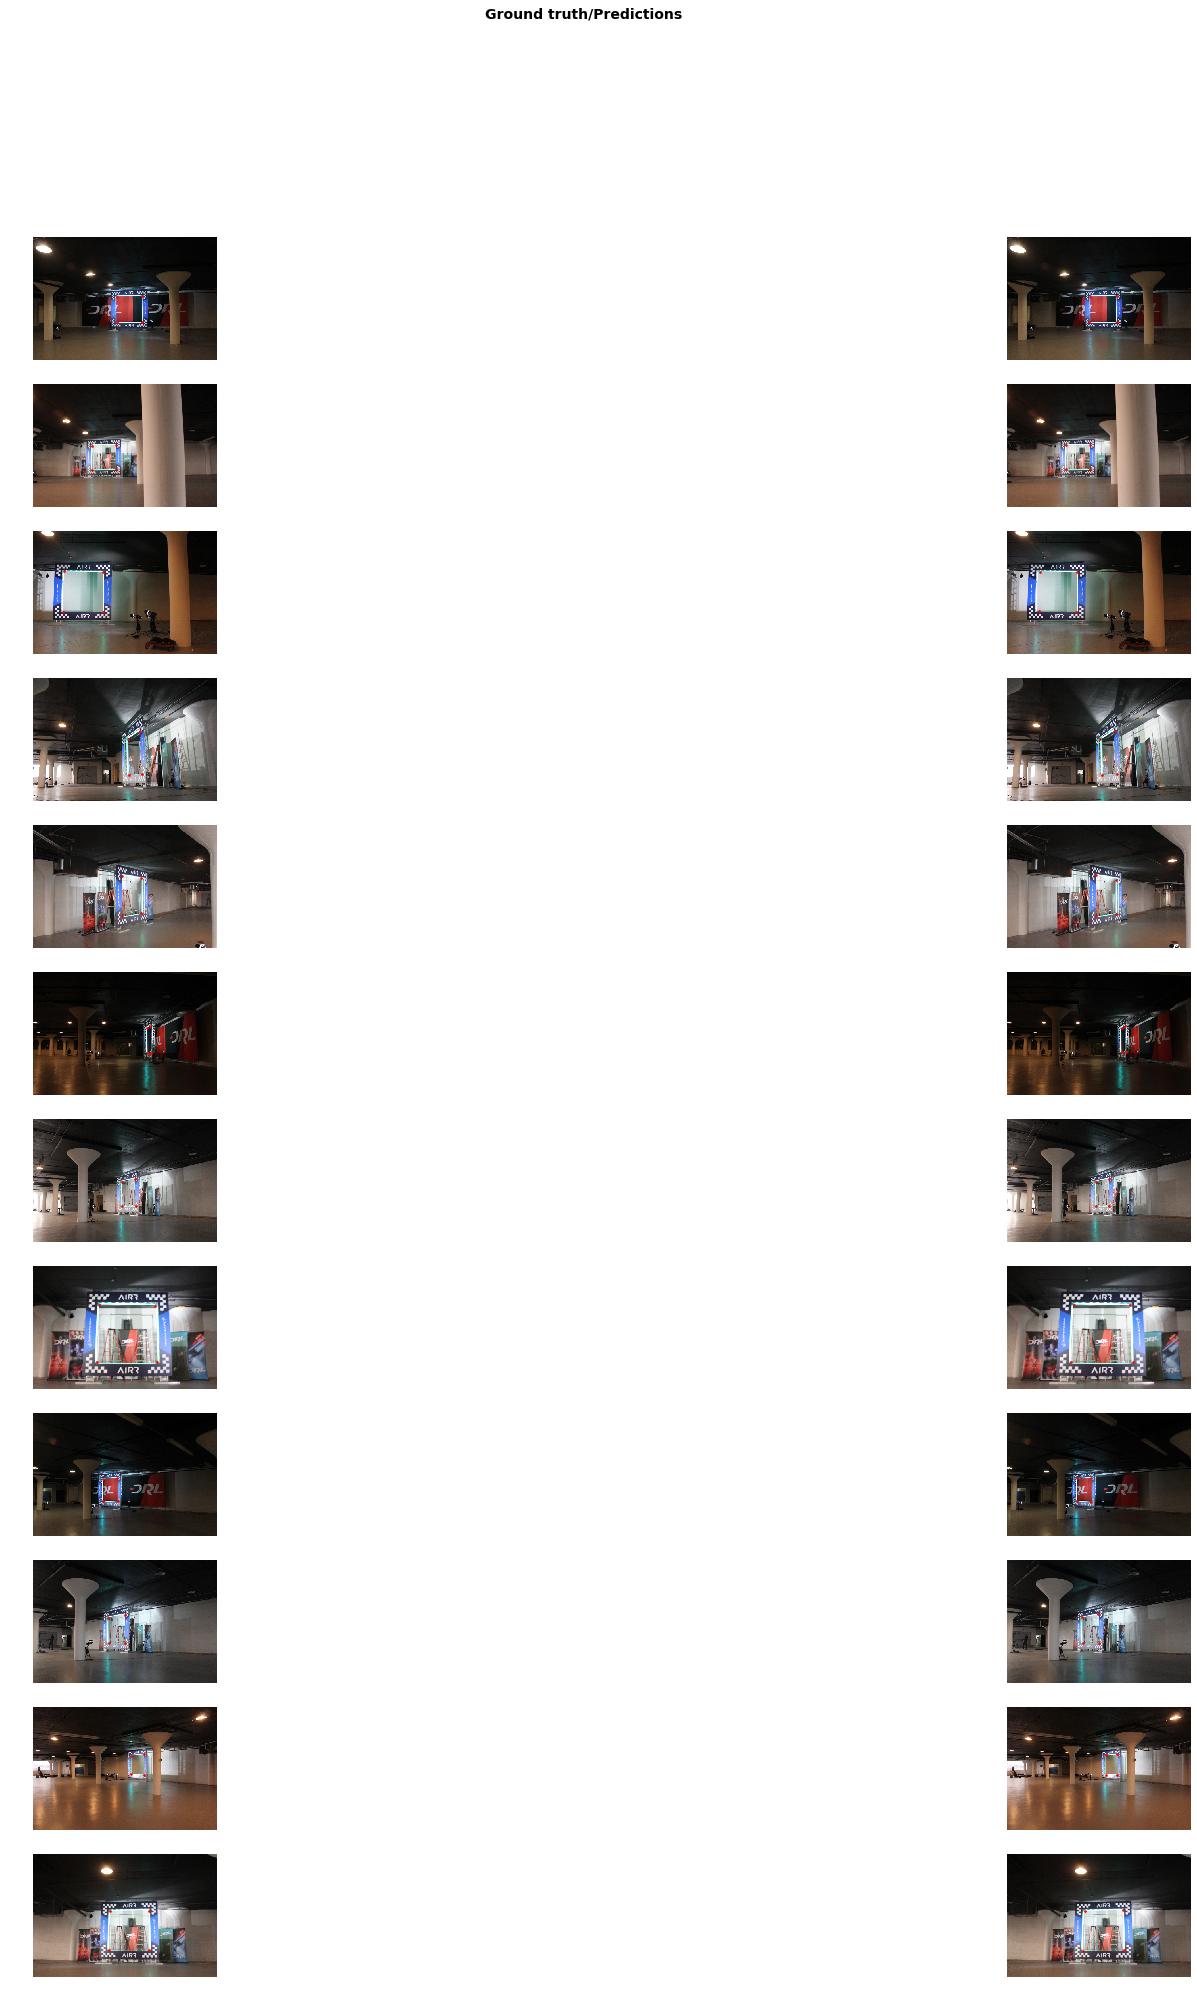

In [59]:
learn.show_results(rows=12, figsize=(32,32))

In [60]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage23_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

total inference time: 2.76 seconds
average inference time: 0.03 seconds


In [61]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage23_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 1.000
IOU: 0.25   Precision: 1.000
IOU: 0.35   Precision: 1.000
IOU: 0.45   Precision: 1.000
IOU: 0.55   Precision: 1.000
IOU: 0.65   Precision: 0.902
IOU: 0.75   Precision: 0.891
IOU: 0.85   Precision: 0.743
IOU: 0.95   Precision: 0.193
COCO mAP for detector is 0.8729066801902116


In [62]:
# generate predictions on test set
tic = time.monotonic()
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)
toc = time.monotonic()

test_preds_fname = path/f'results_v{version}_stage23_test.json'
write_preds_json(data.test_ds, test_preds, size, test_preds_fname)

inference_time(test_preds, tic, toc)

total inference time: 15.25 seconds
average inference time: 0.01 seconds


In [63]:
# score test set
print('To score the test set submit this JSON file to the leaderboard:')
print(test_preds_fname)

To score the test set submit this JSON file to the leaderboard:
/root/.fastai/data/results_v20run1_stage23_test.json


In [64]:
# generate predictions on training set
tic = time.monotonic()
train_preds, _ = learn.get_preds(ds_type=DatasetType.Fix)
toc = time.monotonic()

train_preds_fname = path/f'results_v{version}_stage23_train.json'
write_preds_json(data.train_ds, train_preds, size, train_preds_fname)

inference_time(train_preds, tic, toc)

total inference time: 105.21 seconds
average inference time: 0.01 seconds


In [65]:
# score training set
train_labels_fname = path/f'labels_v{version}_stage23_train.json'
write_labels_json(train_preds_fname, label_path, train_labels_fname)
score(train_labels_fname, train_preds_fname)

# download data back to local
print('Run these commands locally to sync the important stuff!')
print('')
# notebook
print(f'scp -P $VAST_PORT $VAST_HOST:test2/train_v{version}.ipynb $GITREPO')

# results
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v{version}*.json $GITREPO/results')

# models
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v{version}-stage-2-3* $MODELDIR')

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 0.909
IOU: 0.25   Precision: 0.909
IOU: 0.35   Precision: 0.909
IOU: 0.45   Precision: 0.909
IOU: 0.55   Precision: 0.908
IOU: 0.65   Precision: 0.906
IOU: 0.75   Precision: 0.899
IOU: 0.85   Precision: 0.864
IOU: 0.95   Precision: 0.316
COCO mAP for detector is 0.8528949179920456
Run these commands locally to sync the important stuff!

scp -P $VAST_PORT $VAST_HOST:test2/train_v20run1.ipynb $GITREPO
scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v20run1*.json $GITREPO/results
scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v20run1-stage-2-3* $MODELDIR


#### Stage 2.4

In [66]:
#learn.load(save_path/f'v{version}-stage-2-3');

In [67]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


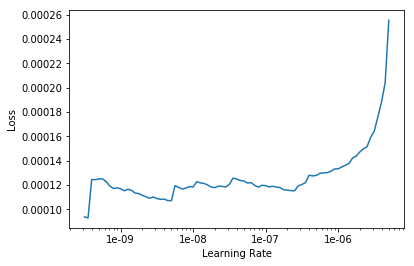

In [68]:
learn.lr_find(start_lr=1e-10, end_lr=1e-5, stop_div=False)
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(150, max_lr=slice(1e-8, 1e-7))  # default 200

In [70]:
learn.save(save_path/f'v{version}-stage-2-4')

In [71]:
torch.save(learn.model, save_path/f'v{version}-stage-2-4-torch.pth')

In [72]:
learn.export(save_path/f'v{version}-stage-2-4-export.pkl')

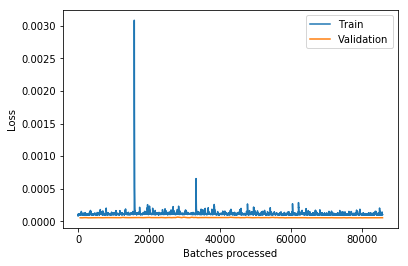

In [73]:
learn.recorder.plot_losses()

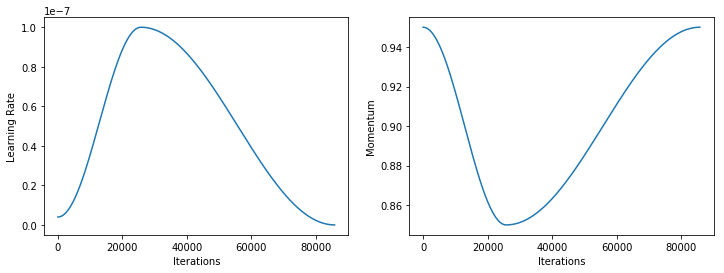

In [74]:
learn.recorder.plot_lr(show_moms=True)

##### Results

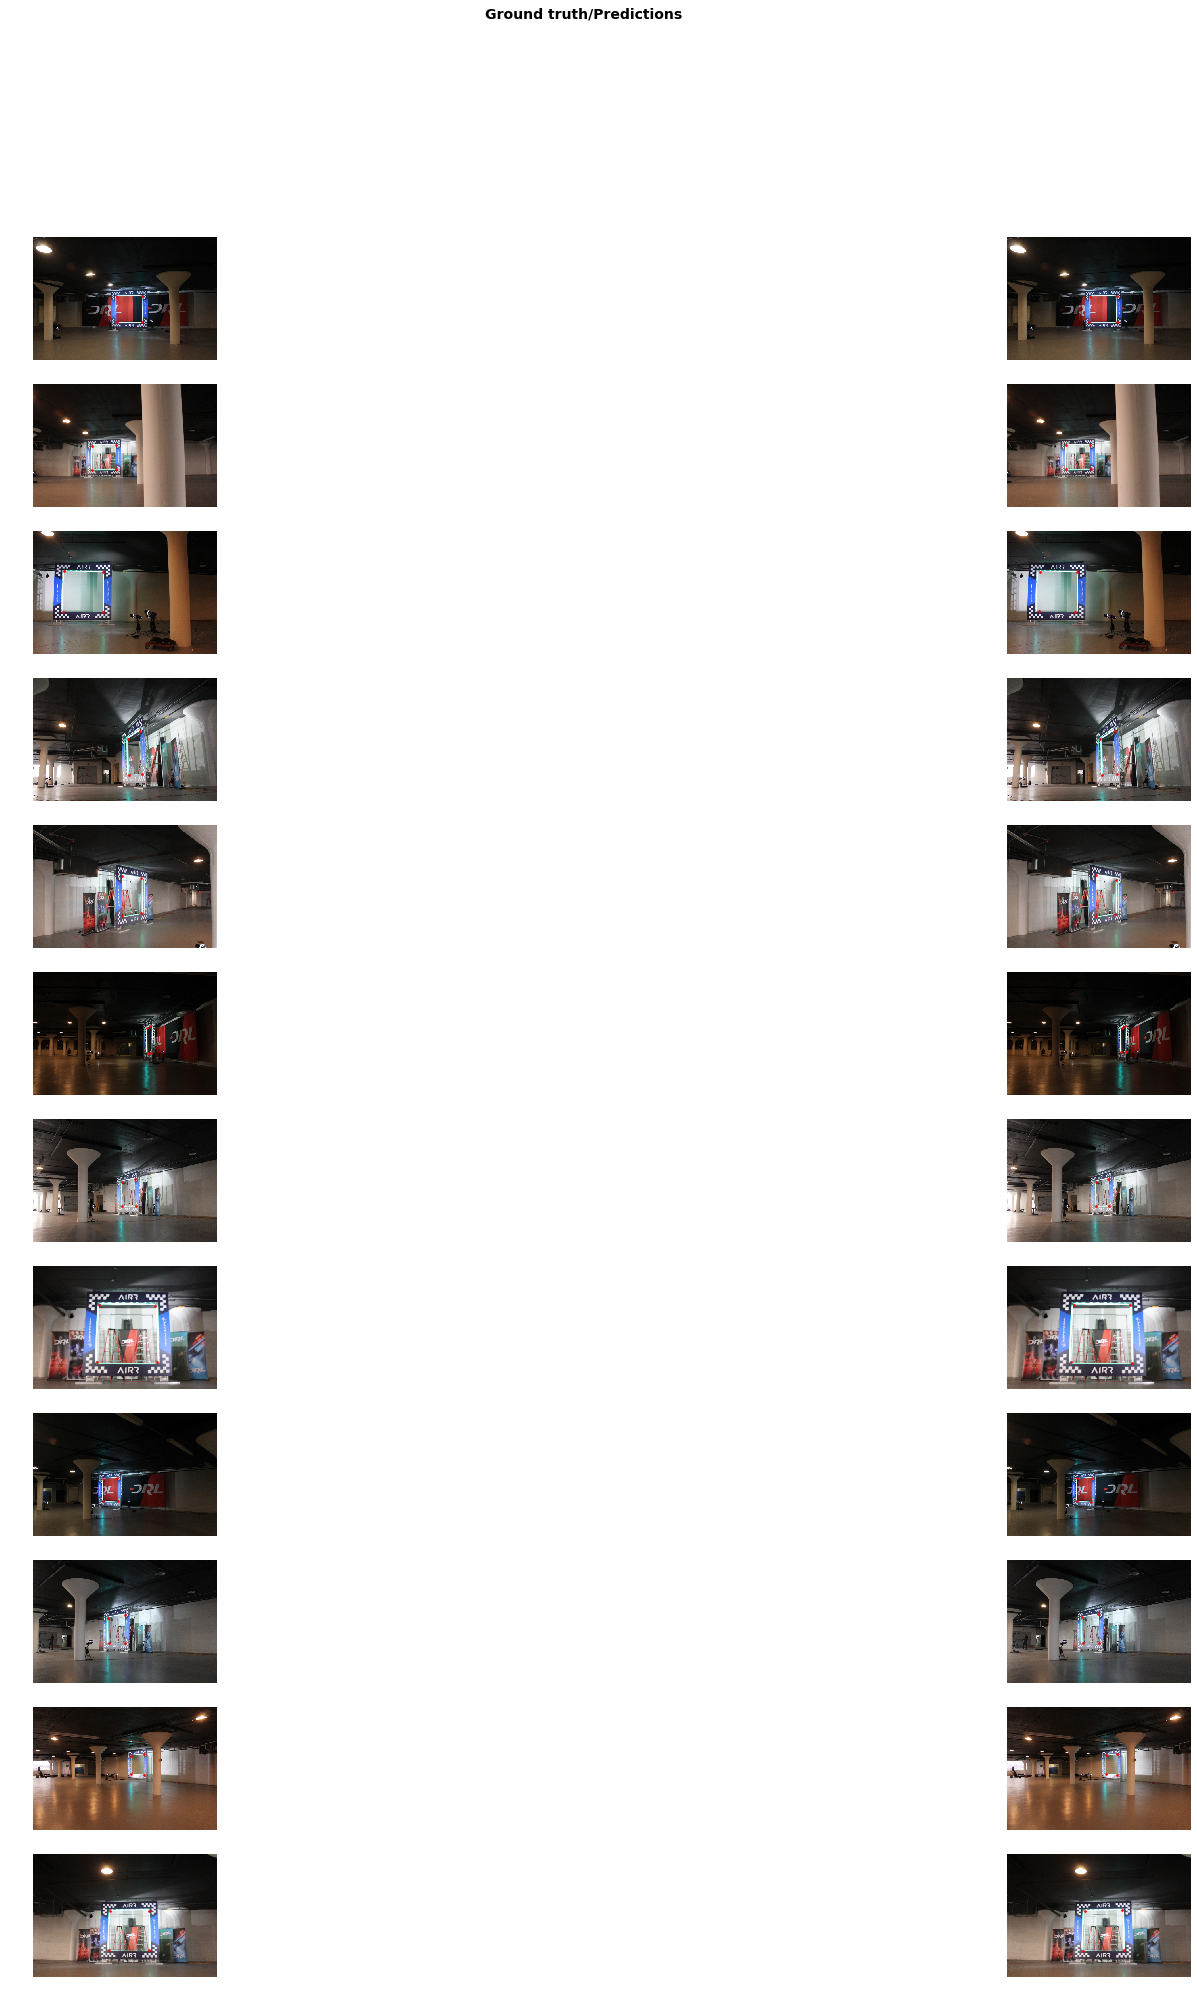

In [75]:
learn.show_results(rows=12, figsize=(32,32))

In [76]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage24_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

total inference time: 2.80 seconds
average inference time: 0.03 seconds


In [77]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage24_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 1.000
IOU: 0.25   Precision: 1.000
IOU: 0.35   Precision: 1.000
IOU: 0.45   Precision: 1.000
IOU: 0.55   Precision: 1.000
IOU: 0.65   Precision: 0.902
IOU: 0.75   Precision: 0.891
IOU: 0.85   Precision: 0.837
IOU: 0.95   Precision: 0.202
COCO mAP for detector is 0.8831691446517608


In [78]:
# generate predictions on test set
tic = time.monotonic()
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)
toc = time.monotonic()

test_preds_fname = path/f'results_v{version}_stage24_test.json'
write_preds_json(data.test_ds, test_preds, size, test_preds_fname)

inference_time(test_preds, tic, toc)

total inference time: 15.02 seconds
average inference time: 0.01 seconds


In [79]:
# score test set
print('To score the test set submit this JSON file to the leaderboard:')
print(test_preds_fname)

To score the test set submit this JSON file to the leaderboard:
/root/.fastai/data/results_v20run1_stage24_test.json


In [80]:
# generate predictions on training set
tic = time.monotonic()
train_preds, _ = learn.get_preds(ds_type=DatasetType.Fix)
toc = time.monotonic()

train_preds_fname = path/f'results_v{version}_stage24_train.json'
write_preds_json(data.train_ds, train_preds, size, train_preds_fname)

inference_time(train_preds, tic, toc)

total inference time: 107.20 seconds
average inference time: 0.01 seconds


In [81]:
# score training set
train_labels_fname = path/f'labels_v{version}_stage24_train.json'
write_labels_json(train_preds_fname, label_path, train_labels_fname)
score(train_labels_fname, train_preds_fname)

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 0.909
IOU: 0.25   Precision: 0.909
IOU: 0.35   Precision: 0.909
IOU: 0.45   Precision: 0.909
IOU: 0.55   Precision: 0.908
IOU: 0.65   Precision: 0.906
IOU: 0.75   Precision: 0.900
IOU: 0.85   Precision: 0.865
IOU: 0.95   Precision: 0.325
COCO mAP for detector is 0.8539642906979676


In [82]:
# download data back to local
print('Run these commands locally to sync the important stuff!')
print('')
# notebook
print(f'scp -P $VAST_PORT $VAST_HOST:test2/train_v{version}.ipynb $GITREPO')

# results
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v{version}*.json $GITREPO/results')

# models
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v{version}-stage-2-4* $MODELDIR')

Run these commands locally to sync the important stuff!

scp -P $VAST_PORT $VAST_HOST:test2/train_v20run1.ipynb $GITREPO
scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v20run1*.json $GITREPO/results
scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v20run1-stage-2-4* $MODELDIR


#### Stage 2.5

In [89]:
learn.load(save_path/f'v{version}-stage-2-4');

In [90]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


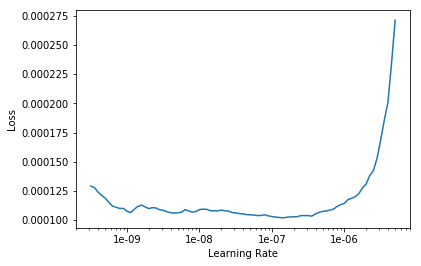

In [91]:
learn.lr_find(start_lr=1e-10, end_lr=1e-5, stop_div=False)
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(180, max_lr=slice(4e-9, 4e-8))  # default 200

In [93]:
learn.save(save_path/f'v{version}-stage-2-5')

In [94]:
torch.save(learn.model, save_path/f'v{version}-stage-2-5-torch.pth')

In [95]:
learn.export(save_path/f'v{version}-stage-2-5-export.pkl')

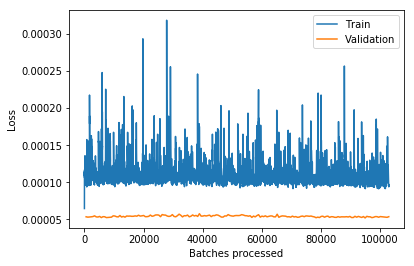

In [96]:
learn.recorder.plot_losses()

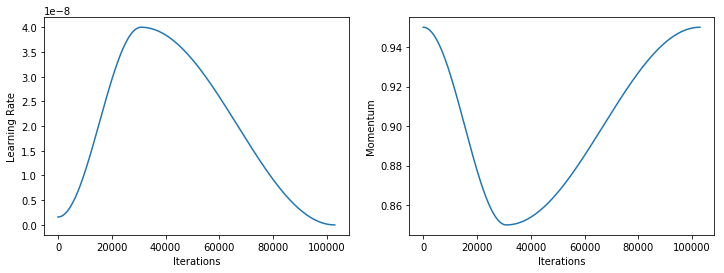

In [97]:
learn.recorder.plot_lr(show_moms=True)

##### Results

In [98]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage25_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

total inference time: 2.83 seconds
average inference time: 0.03 seconds


In [99]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage25_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 1.000
IOU: 0.25   Precision: 1.000
IOU: 0.35   Precision: 1.000
IOU: 0.45   Precision: 1.000
IOU: 0.55   Precision: 1.000
IOU: 0.65   Precision: 0.902
IOU: 0.75   Precision: 0.894
IOU: 0.85   Precision: 0.837
IOU: 0.95   Precision: 0.196
COCO mAP for detector is 0.8829037578646348


In [100]:
# generate predictions on test set
tic = time.monotonic()
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)
toc = time.monotonic()

test_preds_fname = path/f'results_v{version}_stage25_test.json'
write_preds_json(data.test_ds, test_preds, size, test_preds_fname)

inference_time(test_preds, tic, toc)

total inference time: 15.63 seconds
average inference time: 0.01 seconds


In [101]:
# score test set
print('To score the test set submit this JSON file to the leaderboard:')
print(test_preds_fname)

To score the test set submit this JSON file to the leaderboard:
/root/.fastai/data/results_v20run1_stage25_test.json


In [102]:
# generate predictions on training set
tic = time.monotonic()
train_preds, _ = learn.get_preds(ds_type=DatasetType.Fix)
toc = time.monotonic()

train_preds_fname = path/f'results_v{version}_stage25_train.json'
write_preds_json(data.train_ds, train_preds, size, train_preds_fname)

inference_time(train_preds, tic, toc)

total inference time: 107.00 seconds
average inference time: 0.01 seconds


In [103]:
# score training set
train_labels_fname = path/f'labels_v{version}_stage25_train.json'
write_labels_json(train_preds_fname, label_path, train_labels_fname)
score(train_labels_fname, train_preds_fname)

IOU: 0.05   Precision: 0.909
IOU: 0.15   Precision: 0.909
IOU: 0.25   Precision: 0.909
IOU: 0.35   Precision: 0.909
IOU: 0.45   Precision: 0.909
IOU: 0.55   Precision: 0.908
IOU: 0.65   Precision: 0.907
IOU: 0.75   Precision: 0.900
IOU: 0.85   Precision: 0.867
IOU: 0.95   Precision: 0.324
COCO mAP for detector is 0.8451477091063326


In [104]:
# download data back to local
print('Run these commands locally to sync the important stuff!')
print('')
# notebook
print(f'scp -P $VAST_PORT $VAST_HOST:test2/train_v{version}.ipynb $GITREPO')

# results
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v{version}*.json $GITREPO/results')

# models
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v{version}-stage-2-5* $MODELDIR')

Run these commands locally to sync the important stuff!

scp -P $VAST_PORT $VAST_HOST:test2/train_v20run1.ipynb $GITREPO
scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v20run1*.json $GITREPO/results
scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v20run1-stage-2-5* $MODELDIR


#### Stage 2.6

In [105]:
#learn.load(save_path/f'v{version}-stage-2-5');

In [107]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


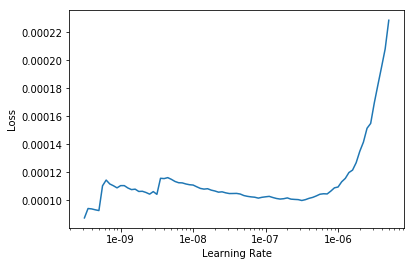

In [108]:
learn.lr_find(start_lr=1e-10, end_lr=1e-5, stop_div=False)
learn.recorder.plot()

In [109]:
learn.fit_one_cycle(200, max_lr=slice(4e-9, 4e-8))  # default 200

In [110]:
learn.save(save_path/f'v{version}-stage-2-6')

In [111]:
torch.save(learn.model, save_path/f'v{version}-stage-2-6-torch.pth')

In [112]:
learn.export(save_path/f'v{version}-stage-2-6-export.pkl')

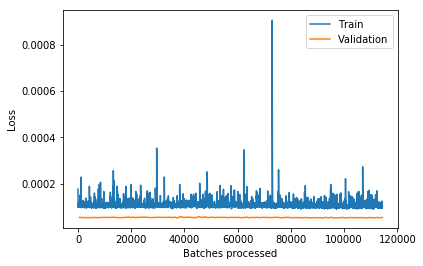

In [113]:
learn.recorder.plot_losses()

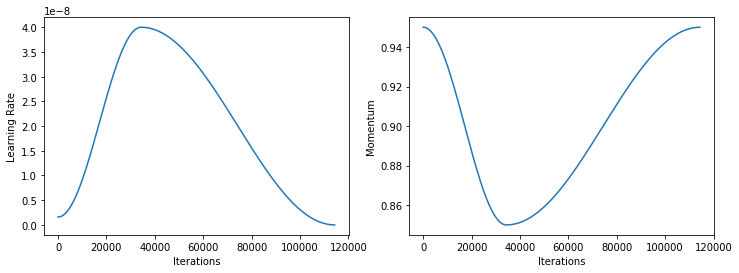

In [114]:
learn.recorder.plot_lr(show_moms=True)

##### Results

In [115]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage26_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

total inference time: 3.05 seconds
average inference time: 0.03 seconds


In [116]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage26_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 1.000
IOU: 0.25   Precision: 1.000
IOU: 0.35   Precision: 1.000
IOU: 0.45   Precision: 1.000
IOU: 0.55   Precision: 1.000
IOU: 0.65   Precision: 0.902
IOU: 0.75   Precision: 0.894
IOU: 0.85   Precision: 0.743
IOU: 0.95   Precision: 0.204
COCO mAP for detector is 0.8743281251547842


In [117]:
# generate predictions on test set
tic = time.monotonic()
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)
toc = time.monotonic()

test_preds_fname = path/f'results_v{version}_stage26_test.json'
write_preds_json(data.test_ds, test_preds, size, test_preds_fname)

inference_time(test_preds, tic, toc)

total inference time: 14.94 seconds
average inference time: 0.01 seconds


In [118]:
# score test set
print('To score the test set submit this JSON file to the leaderboard:')
print(test_preds_fname)

To score the test set submit this JSON file to the leaderboard:
/root/.fastai/data/results_v20run1_stage26_test.json


In [119]:
# generate predictions on training set
tic = time.monotonic()
train_preds, _ = learn.get_preds(ds_type=DatasetType.Fix)
toc = time.monotonic()

train_preds_fname = path/f'results_v{version}_stage26_train.json'
write_preds_json(data.train_ds, train_preds, size, train_preds_fname)

inference_time(train_preds, tic, toc)

total inference time: 109.19 seconds
average inference time: 0.01 seconds


In [120]:
# score training set
train_labels_fname = path/f'labels_v{version}_stage26_train.json'
write_labels_json(train_preds_fname, label_path, train_labels_fname)
score(train_labels_fname, train_preds_fname)

IOU: 0.05   Precision: 1.000
IOU: 0.15   Precision: 0.909
IOU: 0.25   Precision: 0.909
IOU: 0.35   Precision: 0.909
IOU: 0.45   Precision: 0.909
IOU: 0.55   Precision: 0.908
IOU: 0.65   Precision: 0.906
IOU: 0.75   Precision: 0.900
IOU: 0.85   Precision: 0.868
IOU: 0.95   Precision: 0.322
COCO mAP for detector is 0.854034639785558


In [121]:
# download data back to local
print('Run these commands locally to sync the important stuff!')
print('')
# notebook
print(f'scp -P $VAST_PORT $VAST_HOST:test2/train_v{version}.ipynb $GITREPO')

# results
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v{version}*.json $GITREPO/results')

# models
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v{version}-stage-2-6* $MODELDIR')

Run these commands locally to sync the important stuff!

scp -P $VAST_PORT $VAST_HOST:test2/train_v20run1.ipynb $GITREPO
scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v20run1*.json $GITREPO/results
scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v20run1-stage-2-6* $MODELDIR


#### Stage 2.7

In [ ]:
#learn.load(save_path/f'v{version}-stage-2-5');

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find(start_lr=1e-10, end_lr=1e-5, stop_div=False)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(200, max_lr=slice(2e-8, 2e-7))  # default 200

In [ ]:
learn.save(save_path/f'v{version}-stage-2-7')

In [ ]:
torch.save(learn.model, save_path/f'v{version}-stage-2-7-torch.pth')

In [ ]:
learn.export(save_path/f'v{version}-stage-2-7-export.pkl')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

##### Results

In [ ]:
# generate predictions on validation set
tic = time.monotonic()
valid_preds, _ = learn.get_preds(ds_type=DatasetType.Valid)
toc = time.monotonic()

valid_preds_fname = path/f'results_v{version}_stage27_valid.json'
write_preds_json(data.valid_ds, valid_preds, size, valid_preds_fname)

inference_time(valid_preds, tic, toc)

In [ ]:
# score validation set
valid_labels_fname = path/f'labels_v{version}_stage27_valid.json'
write_labels_json(valid_preds_fname, label_path, valid_labels_fname)
score(valid_labels_fname, valid_preds_fname)

In [ ]:
# generate predictions on test set
tic = time.monotonic()
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)
toc = time.monotonic()

test_preds_fname = path/f'results_v{version}_stage27_test.json'
write_preds_json(data.test_ds, test_preds, size, test_preds_fname)

inference_time(test_preds, tic, toc)

In [ ]:
# score test set
print('To score the test set submit this JSON file to the leaderboard:')
print(test_preds_fname)

In [ ]:
# generate predictions on training set
tic = time.monotonic()
train_preds, _ = learn.get_preds(ds_type=DatasetType.Fix)
toc = time.monotonic()

train_preds_fname = path/f'results_v{version}_stage27_train.json'
write_preds_json(data.train_ds, train_preds, size, train_preds_fname)

inference_time(train_preds, tic, toc)

In [ ]:
# score training set
train_labels_fname = path/f'labels_v{version}_stage27_train.json'
write_labels_json(train_preds_fname, label_path, train_labels_fname)
score(train_labels_fname, train_preds_fname)

In [ ]:
# download data back to local
print('Run these commands locally to sync the important stuff!')
print('')
# notebook
print(f'scp -P $VAST_PORT $VAST_HOST:test2/train_v{version}.ipynb $GITREPO')

# results
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/results_v{version}*.json $GITREPO/results')

# models
print(f'scp -P $VAST_PORT $VAST_HOST:.fastai/data/saved_models/v{version}-stage-2-7* $MODELDIR')